# Digital Earth Africa Demo - Crop Growing Trend

This notebook gives an example of using DEAfrica products to identify likely irrigated crops and plot growth trend over multiple years.

Two products derived from Landsat Surface Reflectance data are used:
1. NDVI derived from Landsat Surface Reflectance.
2. Fractional Cover.

Following steps are demonstrated:
1. [Find a clear Landsat 8 image during the dry season and visualize](#clear_image)
2. [Segement the clear image using NDVI values](#segmentation) 
3. [Select a segement and retrieve the fractional cover time series](#fc_series)


## 1. Find a clear Landsat 8 image during the dry season and visualize <a name="clear_image"></a>

In [1]:
%pylab notebook

from matplotlib import pyplot as plt
import xarray as xr

# import datacube modules
import datacube
from datacube.storage import masking

Populating the interactive namespace from numpy and matplotlib


In [2]:
dc = datacube.Datacube(app='crop_demo')

In [3]:
# define area
lat = (-3.27, -3.16)
lon = (29.31,29.41)
crs = 'EPSG:32635'

In [4]:
# Load dry season data
dry_data = dc.load(product = 'ls8_usgs_sr_scene', 
                     # Location can be defined in Lat/Lon or X/Y and a projection.
                     lat = lat, lon = lon,
                     # Constrain the time period
                     time = ('2017-06-01', '2017-08-01'),
                     # Define output specifications; default interploation in reprojection is 'nearest'
                     output_crs = crs,
                     resolution = (-30, 30),
                     # Only load specified measurements; default is to load all measurements
                     measurements = ['blue','green','red','nir','swir1','pixel_qa']
                    )

In [5]:
# select the most clear image
mask = masking.make_mask(dry_data.pixel_qa, cloud='no_cloud', cloud_shadow='no_cloud_shadow', nodata=False)
clear_fracs = mask.groupby('time').mean(dim=xr.ALL_DIMS)
clear = dry_data.isel(time=clear_fracs==clear_fracs.max()).isel(time=0).squeeze()

<IPython.core.display.Javascript object>


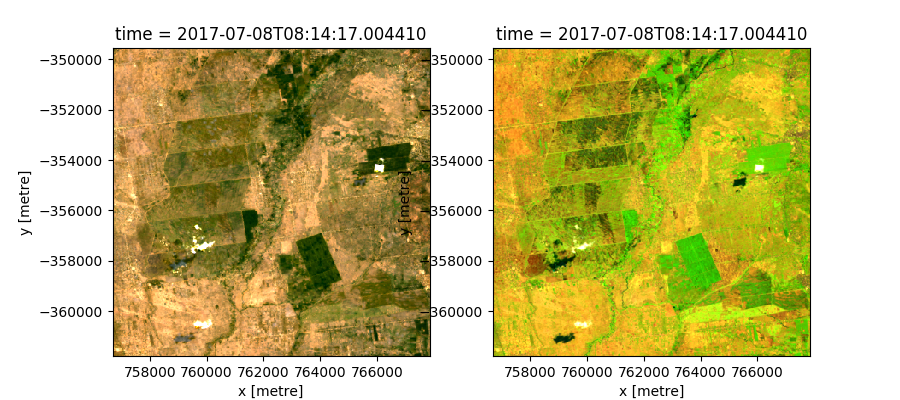

In [6]:
# plot in true and false color
fig, axes = plt.subplots(1,2, figsize=(9,4))
clear[['red','green','blue']].to_array().plot.imshow(robust=True, ax=axes[0]);
clear[['swir1','nir','green']].to_array().plot.imshow(robust=True, ax=axes[1]);

## 2. Segement the clear image using NDVI values <a name="segmentation"></a>

In [7]:
from skimage.segmentation import quickshift, mark_boundaries
from skimage import exposure

In [8]:
# calculate ndvi
ndvi = (clear.nir-clear.red)/(clear.nir+clear.red)

In [9]:
# segment and add the segmentation result to image array
seg = quickshift(ndvi.values, convert2lab= False, kernel_size=5)
clear['seg'] = ('y','x'), seg

## 3. Select a segement and retrieve the fractional cover time series <a name="fc_series"></a>

In [10]:
# rescale the image for visualization
vis = clear[['red','green','blue']].to_array(dim='band').transpose('y','x','band')
p_low, p_high = vis.quantile((0.02,0.98)).values
vis =exposure.rescale_intensity(vis.values.astype(float), in_range=(p_low, p_high), out_range = (0, 1.))

In [11]:
time_period = ('2017-01-01', '2018-01-01')
query = {'lat':lat, 'lon':lon,
        'time':time_period, 
        'output_crs':crs, 'resolution':(-30,30)}
dss_wofs = dc.find_datasets(product='ls_usgs_wofs_scene',**query)
#dss_fc = dc.find_datasets(product='ls_usgs_fc_scene',**query)

In [12]:
def load_fc(clear, seg, seg_mask, ax0, ax, crs=crs, clear_frac=0.8,
            time_period = time_period,
            dss_wofs=dss_wofs):

    # mark segment
    plot_segs(vis, seg, seg_mask=seg_mask, ax = ax0)

    # only retrieve the bounding area for the segment
    patch = clear.where(seg_mask).dropna(dim='x', how='all').dropna(dim='y', how='all')
    query = {'x':(patch.x.min().values, patch.x.max().values), 'y':(patch.y.min().values, patch.y.max().values),
             'crs': crs,
             'time':time_period, 
             'output_crs':crs, 'resolution':(-30,30)}   
    # load cloud mask
    wofs = dc.load(product='ls_usgs_wofs_scene', datasets = dss_wofs, 
                   group_by = 'solar_day', **query)
    mask = masking.make_mask(wofs.water, cloud=False, cloud_shadow=False, nodata=False)
    
    # only keep mostly clear times
    good = mask.groupby('time').mean(dim=xr.ALL_DIMS).values>=clear_frac
    mask = mask.isel(time=good)

    ds_set =[]
    time_query = query.copy()
    for itime, time in enumerate(mask.time.values):
        time_query['time'] = (str(time.astype('M8[D]')), str(time.astype('M8[D]')))        
        ds = dc.load(product='ls_usgs_fc_scene',
                    group_by = 'solar_day', measurements=['BS','PV','NPV'], **time_query)
        ds_set.append(ds.where(mask.isel(time=itime)))
    data = xr.concat(ds_set, dim='time')

    # clip to the patch
    data = data.where(clear.seg)

    # mean fractions over time
    ax.clear()
    for color, band, label in zip(['r','g','b'], ['BS', 'PV', 'NPV'],['bare','green','non-green']):
        series = data[band].groupby('time').mean()
        series.plot(ax = ax, color=color, label=label)
    ax.legend()
    ax.set_ylim((0,100))
    ax.set_xlabel('')
    return data

def plot_segs(vis, seg, ax, seg_mask = None):
    ax.clear()
    ax.imshow(mark_boundaries(vis, seg));
    if not seg_mask is None:
        overlay = mark_boundaries(np.zeros_like(vis), clear.seg.where(seg_mask,0).values, color=(1,0,0),mode='thick')
        overlay = np.append(overlay, (overlay!=0).any(axis=-1)[:,:,np.newaxis], axis =-1)
        ax.imshow(overlay)
    ax.set_xticks([])
    ax.set_yticks([])


<IPython.core.display.Javascript object>


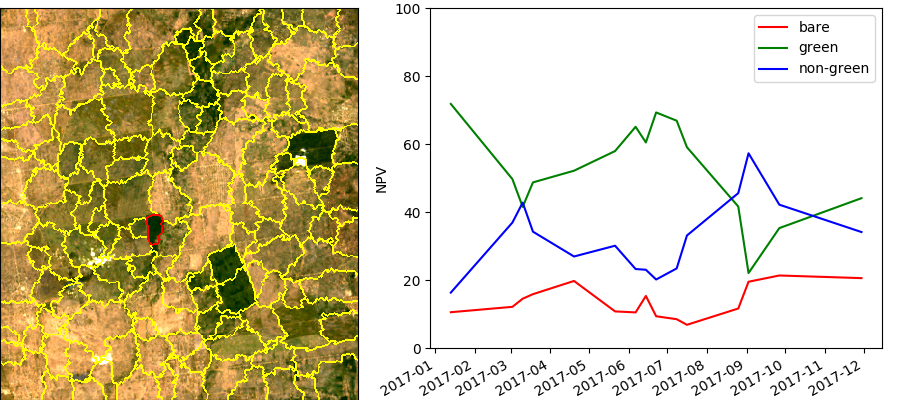

In [13]:
# interactively pick a segment and plot FC timeseries

fw = 9
fh = 4
f = plt.figure(figsize=(fw, fh))

axh = 0.98
axw = fh*axh*vis.shape[1]/vis.shape[0]/fw
ax0 = f.add_axes([0.,0.,axw,axh])
ax1 = f.add_axes([axw+0.08,0.13,0.9-axw,axh-0.13])

plot_segs(vis, seg, ax0, seg_mask =None)

ax1.axis('off')

def onclick(event):
    seg_mask = seg == seg[int(event.ydata), int(event.xdata)]
    load_fc(clear, seg, seg_mask, ax0, ax1)
    
cid =f.canvas.mpl_connect('button_press_event', onclick)